# Beispiel 17.4: Anfahrverhalten eines Katalysatorpellets

Bearbeitet von Alexander Zirn

Dieses Beispiel befindet sich im Lehrbuch auf der Seite 244-245. Die Nummerierung der aus dem Lehrbuch verwendeten Gleichungen entspricht der Nummerierung im Lehrbuch. Gleichungen, die nur im vorliegenden Beispiel verwendet werden, sind durich einfache fortlaufende Zahlen gekennzeichnet.

In [1]:
# IMPORT SECTION

import numpy as np                     # import of numpy
from scipy.integrate import solve_ivp  # important for boundary value problem
import matplotlib.pyplot as plt        # import of matplotlib
from matplotlib import cm              # import colormap
from scipy.integrate import simpson    # import of integration function
import matplotlib.colors as mcolors    # import of colorway

# 1. Implementierung
## 1.1 Arrhenius-Ansatz
Die Abhängigkeit der dimensionslosen Reaktionsgeschwindigkeitskonstante von der dimensionslosen Temperatur $\vartheta$ wird durch das Arrhenius-Ansatz beschrieben:

\begin{align}
  \frac{k_1(\vartheta)}{k_\mathrm{ref}}=\frac{k_{0,1}}{k_{0,\mathrm{ref}}}\exp\left(\gamma \left(\frac{1}{\vartheta_\mathrm{ref}}-\frac{1}{\vartheta}\right)\right),\tag{1}\\
\end{align}

mit der Arrhenius-Zahl $\gamma$ sowie:

\begin{align}
    \vartheta_\mathrm{ref}&=1,\tag{2}\\
    \frac{k_{0,1}}{k_{0,\mathrm{ref}}}&=1.\tag{3}\\
 \end{align}

 Nachfolgender Code zeigt die Implementierung des Arrhenius-Ansatzes:

In [2]:
# definition of function for dimensionless kinetic constant via Arrhenius law

def k_j_k_ref(vartheta, gamma):
    """ temperature dependent normalized kinetic constant

    Parameters
    ----------
    vartheta : array of arbitrary size
        dimensionless temperature in a.u.
    gamma : array of size 1
        Arrhenius-number in 1

    Returns
    -------
    array of size 1
        temperature dependent normalized kinetic constant in 1
    """
   
    k = np.exp(gamma * (1 - 1 / vartheta)) # Arrhenius law
    
    return k  

## 1.2 Reaktionsgeschwindigkeit

<div style="text-align: justify">

Gemäß Beispiel 17.4 wird eine heterogen katalysierte Reaktion 1. Ordnung angenommen. Die dimensionslose Reaktionsgeschwindigkeit $\omega_\mathrm{1}$ kann mithilfe des Arrhenius-Ansatzes sowie dem Restanteil $f_\mathrm{1,Kat}$ wie folgt ausgedrückt werden:

\begin{align}
\omega_\mathrm{1}=\frac{k_1(\vartheta)}{k_\mathrm{ref}}~f_\mathrm{1}\tag{4}.
\end{align}

Die dimensionslose Reaktionsgeschwindigkeit ist im Folgenden als Funktion "omega" implementiert. Als Variablen werden der Restanteil im Katalysatorpellet, die mittleren Kühlmitteltemperatur sowie die Arrhenius-Zahl gewählt und sind der Funktion zu übergeben.

In [3]:
def omega(f, vartheta, gamma):
    """ reaction rate function

    Parameters
    ----------
    f_i : array
        residual fraction in 1
    T_i : array
        dimensionless temperature in 1

    Returns
    -------
    array
        dimensionless reaction rate in 1
    """

    omega = f * k_j_k_ref(vartheta, gamma)

    return omega

## 1.3. Material- und Energiebilanz

Die Materialbilanzen ergeben sich für ebene Geometrie ($a=0$) zu:

\begin{align}
\frac{\partial f_{1,\mathrm{Kat}}}{\partial\theta_\mathrm{Kat}}&=\frac{\partial^{2} f_{1,\mathrm{Kat}}}{\partial\chi^{2}}-\phi^{2}\,\omega_{1},\tag{1}\\
\frac{1}{Le}\frac{\partial \vartheta_{\mathrm{Kat}}}{\partial\theta_\mathrm{Kat}}&=\frac{\partial^{2} \vartheta_{\mathrm{Kat}}}{\partial\chi^{2}}+\frac{\beta\,\phi^{2}}{Le}\,\omega_{1}.\tag{2}
\end{align}

Die Rand- und Anfangsbedingungen ergeben sich zu:

\begin{align}
f_{1,\mathrm{Kat}}\left(\theta_\mathrm{Kat}=0,\chi\right)=0,\tag{3}\\
f_{1,\mathrm{Kat}}\left(\theta_\mathrm{Kat}>0,\chi=1\right)=1,\tag{4}\\
\frac{\partial\,f_{1,\mathrm{Kat}}}{\partial\,\chi}\left(\theta_\mathrm{Kat}>0,\chi=0\right)=0.\tag{5}
\end{align}

Da partielle Differenzialgleichungen nicht trivial in Python zu implementieren sind, werden die Gleichungen mittels der Finite-Differenzen-Methode in ein gewöhnliches Differenzialgleichungssystem zerlegt. Laterale Gradienten werden dabei mittels finiter Differenzen so ausgedrückt, dass sich für jede lateriale Position $x$ eine Differenzialgleichung ergibt: 

\begin{align}
\frac{\partial f_{1,\mathrm{Kat}}[x]}{\partial \theta_\mathrm{Kat}} &=\frac{f_{1,\mathrm{Kat}}[x+1]-2\,f_{1,\mathrm{Kat}}[x]\,+f_{1,\mathrm{Kat}}[x-1]}{{\Delta \chi}^2}-\phi^{2}\,\frac{k_1(\vartheta)}{k_\mathrm{ref}}~f_{1,\mathrm{Kat}}[x],\tag{6}\\
\frac{1}{Le}\frac{\partial \vartheta_\mathrm{Kat}[x]}{\partial \theta_\mathrm{Kat}} &=\frac{\vartheta_\mathrm{Kat}[x+1]-2\,\vartheta_\mathrm{Kat}[x]\,+\vartheta_\mathrm{Kat}
[x-1]}{{\Delta \chi}^2}+\frac{\beta\,\phi^{2}}{Le}\,\frac{k_1(\vartheta)}{k_\mathrm{ref}}~f_{1,\mathrm{Kat}}[x].\tag{7}  
\end{align}

Diese können dann mittels des Anfangswertsolvers "solve_ivp" gelöst werden.


Für die Position $x=0$ wird die linke Randbedingung eingesetzt:
\begin{align}
\frac{\partial f_{1,\mathrm{Kat}}[0]}{\partial \theta_\mathrm{Kat}} &=\frac{f_{1,\mathrm{Kat}}[1]-\,f_{1,\mathrm{Kat}}[0]\,}{{\Delta \chi}^2}-\phi^{2}\,\frac{k_1(\vartheta)}{k_\mathrm{ref}}~f_{1,\mathrm{Kat}}[0],\tag{8}\\
\frac{1}{Le}\frac{\partial \vartheta_\mathrm{Kat}[0]}{\partial \theta_\mathrm{Kat}} &=\frac{\vartheta_\mathrm{Kat}[1]-\vartheta_\mathrm{Kat}[0]\,}{{\Delta \chi}^2}+\frac{\beta\,\phi^{2}}{Le}\,\frac{k_1(\vartheta)}{k_\mathrm{ref}}~f_{1,\mathrm{Kat}}[0].\tag{9}  
\end{align}

Analog dazu ergibt sich für die rechte Randbedingunge für $x=N$:

\begin{align}
\frac{\partial f_{1,\mathrm{Kat}}[N]}{\partial \theta_\mathrm{Kat}} &=0,\tag{10}\\
\frac{\partial \vartheta_\mathrm{Kat}[N]}{\partial \theta_\mathrm{Kat}} &=0.\tag{11}
\end{align}

Das System an Differenzialgleichungen wird in der Funktion "pde_system" hinterlegt, wobei diese für jede radiale Position $x$ zwei Differenzialgleichungen zurückgibt, was die Laufvariable $y$ ausdrückt.

In [4]:
# system of partial differential equations

def pde_system(theta, y, beta, phi, Le, gamma):
    """ PDE system 

    Parameters
    ----------
    theta : array of size 11
        dimensionless time in a.u.
    y : array of size 2 * N_disc
        contains all concentrations and temperature in a.u.
    beta : array of size 1
        Prater-number for catalyst in 1
    phi : array of size 1
        Thiele-modulus in 1
    Le : array of size 1
        Lewis-number in 1
    gamma : array of size 1
        Arrhenius-number in 1

    Returns
    -------
    array of size 2*N_disc
        derivatives of all concentrations and temperature
    """
    
    # numerical parameters for function 
    N = N_disc_x - 1 # counting variable for number of ODEs
    
    # definition of empty vectors
    df_dtheta   = np.zeros(N_disc_x) # empty vector for all ODEs
    dvartheta_dtheta = np.zeros(N_disc_x)
    
    # renaming variables
    f        = y[0:N_disc_x]
    vartheta = y[N_disc_x:2 * N_disc_x]

    ### --- flat geometry --- ###
    # material balance
    df_dtheta[0] = (f[1] - f[0]) / delta_chi**2 - phi**2 * omega(f[0], vartheta[0], gamma) # boundary condition for chi = 0
    
    for i in np.arange(1, N):
        df_dtheta[i] = (f[i + 1] - 2 * f[i] + f[i - 1]) / delta_chi**2 - phi**2 * omega(f[i], vartheta[i], gamma)  # ODE

    df_dtheta[N] = 0 # boundary condition for chi = 1
    
    # energy balance
    dvartheta_dtheta[0] = Le * (vartheta[1] - vartheta[0]) / delta_chi**2 + beta * phi**2 * omega(f[0], vartheta[0], gamma) # general ode for membrane @ x=0, left boundary of membrane inserted
    
    for i in np.arange(1, N):
        dvartheta_dtheta[i] = Le * (vartheta[i + 1] - 2 * vartheta[i] + vartheta[i - 1]) / delta_chi**2 + beta * phi**2 * omega(f[i], vartheta[i], gamma)  # ODE
    
    dvartheta_dtheta[N] = 0 
    
    return np.hstack((df_dtheta, dvartheta_dtheta))

## 1.4 Numerische Lösung
Das Differenzialgleichungssystem, hinterlegt in "pde_system", wird von der Funktion "solver" für variable Werte der Prater-Zahl $Pr$, des Thiele-Moduls $\phi$, der Lewis-Zahl $Le$ sowie der Arrhenius-Zahl $\gamma$ gelöst. Zusätzlich kann die Anfangskonzentration des Reaktanten $A_1$ mittels "initial_concentration" sowie die Anfangstemperatur mittels "initial_temperature" festgelegt werden. Für die Lösung des Differenzialgleichungssystems wird der numerische Anfangswertsolver "solve_ivp" verwendet.

In [5]:
def solver(pde_system, theta_eval, beta, phi, Le, gamma, initial_concentration, initial_temperature):
    """ solver function

    Parameters
    ----------
    pde_system : array of size 2*N_disc
        ODE equations to solve
    theta_eval : array of size N_disc
        all time values in a.u.
    beta : array of size 1
        Prater-number for catalyst in 1
    phi : array of size 1
        Thiele-modulus in 1
    Le : array of size 1
        Lewis-number in 1
    gamma : array of size 1
        Arrhenius-number in 1
    filled : 0 - empty or 1 - filled
        determines initial concentration within reactor, only extrema possible
    initial_temperature : array of size 1
        initial temperature in a.u.

    Returns
    -------
    array of size 2*N_disc,
        solutions for all concentrations and temperature in a.u.
    """
    
    theta_span = [theta_eval[0], theta_eval[-1]]

    ## initial conditions
    
    if initial_concentration == 0: # empty
        y_0          = np.hstack(( np.zeros(N_disc_x), initial_temperature * np.ones(N_disc_x))) 
        y_0[N_disc_x-1] = 1
        y_0[-1]=1
        # y_0          = np.hstack((0.5 * np.ones(N_disc_x), 1.5 * np.ones(N_disc_x))) 
        # y_0[N_disc_x-1] = 1
        
    else: # filled
        y_0     = np.hstack((initial_concentration * np.ones(N_disc_x), initial_temperature * np.ones(N_disc_x))) 
        y_0[N_disc_x-1] = 1
        y_0[-1]=1
    c_x_t_sol = solve_ivp(pde_system, theta_span, y0 = y_0, method = 'Radau', t_eval = theta_eval, args = (beta, phi, Le, gamma)).y # solving PDE with solve_ivp 

    return c_x_t_sol

Die erforderlichen numerischen Parameter sind im Folgenden gegeben:

In [6]:
# numerical parameters

## values in x-direction
N_disc_x    = 71 # dynamic discretization
chi_span    = np.linspace(0, 1, N_disc_x) # vector of all possible x values
delta_chi   = chi_span[1] - chi_span[0] # differential element of x

## values in t-direction
N_disc_t = 2001
theta_max  = 2                          # maximal possible time
theta_span = [0, theta_max]                   # lower and upper time limit
theta_eval = np.linspace(theta_span[0], theta_span[-1], N_disc_t)# vector of all possible t values 

## generating grid
var_y_dyn, var_x_dyn = np.meshgrid(theta_eval, chi_span)

# 2. Ergebnisse
Im Weiteren soll das Gleichungssystem für ein Set an Parametern (vgl. S. 245) gelöst werden. Dieses ist im Folgenden definiert:

In [7]:
# set of parameters for variant 1
# Lehrbuch S. 245

beta  = 0.2 # Prater-Zahl
phi   = 1.3 # Thiele-Modul
Le    = 0.6 # Lewis-Zahl
gamma = 25  # Arrhenius-Zahl

Die ermittelten Ergebnisse werden in Verläufe des Restanteils und der dimensionslosen Temperatur unterteilt. Die ortsabhängigen Verläufe werden zu jedem Zeitpunkt über die Ortskoordinate $\chi$ gemittelt, um zeitlich Verläufe in Abhängigkeit von $\theta$ zu erhalten.

In [8]:
# solving pde with parameters from variant 1

c_x_t_sol = solver(pde_system, theta_eval, beta, phi, Le, gamma, 0, 1)

# dividing solution matrix c_x_t_sol into residual fraction and temperature solutions
ResFrac = c_x_t_sol[0 : N_disc_x,           :] # residual fraction solutions
Temp    = c_x_t_sol[N_disc_x : 2 * N_disc_x,:] # temperature solutions

## definition of empty matrices
ResFrac_av = np.zeros(N_disc_t)
Temp_av    = np.zeros(N_disc_t)


## calculation of spacially averaged values
for i in np.arange(0, N_disc_t):
    ResFrac_av[i] = 1 / (chi_span[-1]) * simpson(ResFrac[:,i], chi_span) 
    Temp_av[i]    = 1 / (chi_span[-1]) * simpson(Temp[:,i],    chi_span) 

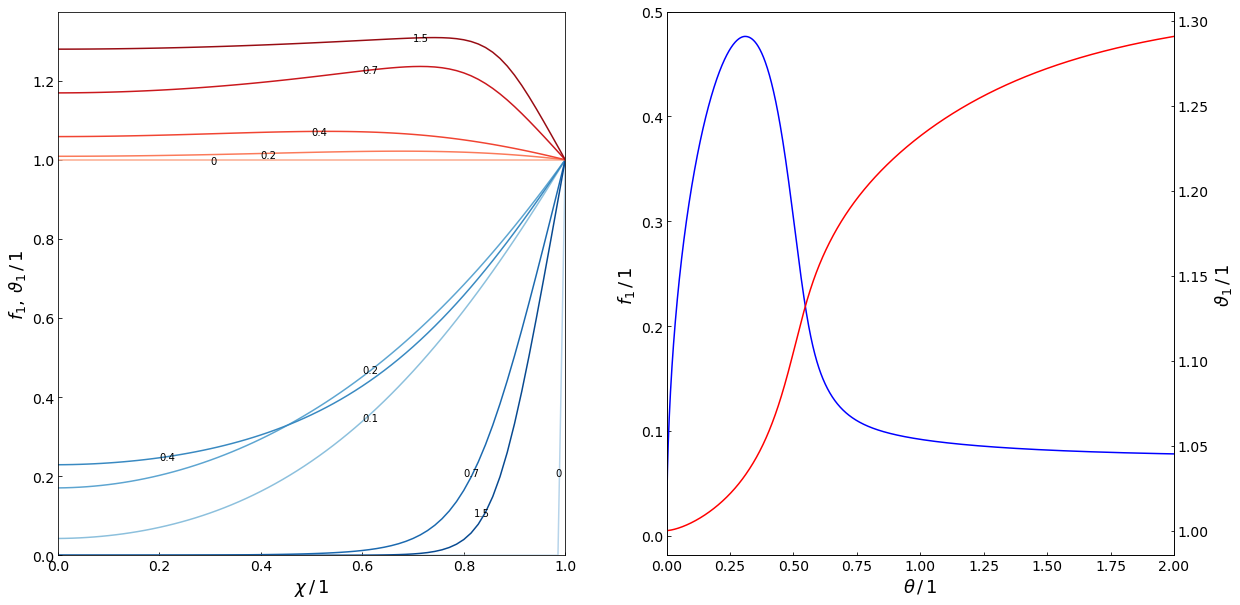

In [9]:
# Setting the figure size

fig = plt.subplots(1, 2, figsize = (20, 10)) # fixing size of diagram

Points_in_time_f = np.array((0, int((0.1 / theta_max) * N_disc_t), int((0.2 / theta_max) * N_disc_t), int((0.4 / theta_max) * N_disc_t), int((0.7 / theta_max) * N_disc_t), int((1.5 / theta_max) * N_disc_t))) # regarded points in time
Points_in_time_theta = np.array((0, int((0.2 / theta_max) * N_disc_t), int((0.4 / theta_max) * N_disc_t), int((0.7 / theta_max) * N_disc_t), int((1.5 / theta_max) * N_disc_t))) # regarded points in time

colormap_blue = cm.Blues
colormap_red  = cm.Reds

color_x_f= np.linspace(0.3,0.9, Points_in_time_f.size)
color_x_theta= np.linspace(0.3,0.9, Points_in_time_theta.size)

plt.subplot(1, 2,1)

plt.plot(chi_span, ResFrac[:,Points_in_time_f[0]], color = colormap_blue(color_x_f[0]),  label = r'$f_1$') # plots dynamic solutions for all gas concentrations
plt.plot(chi_span, Temp[:,Points_in_time_theta[0]],    color = colormap_red(color_x_theta[0]), label = r'$\vartheta $') # plots dynamic solutions for all gas concentrations
for i in np.arange(1,Points_in_time_f.size):
    plt.plot(chi_span, ResFrac[:,Points_in_time_f[i]], color = colormap_blue(color_x_f[i])) # plots dynamic solutions for all gas concentrations
for i in np.arange(1,Points_in_time_theta.size):
    plt.plot(chi_span, Temp[:,Points_in_time_theta[i]],    color = colormap_red(color_x_theta[i])) # plots dynamic solutions for all gas concentrations
plt.xlim(chi_span[0],chi_span[-1]) # sets limits for x-axis
plt.ylim(0, ) # sets limits for y-axis
plt.ylabel(r"$f_1,\,\vartheta_1\,/\,1$ ", fontsize = 18)# adds label to x-axis
plt.xlabel("$\chi\,/\,1$", fontsize=18) # adds label to y-axis
plt.tick_params(labelsize=14,direction='in') # turns direction of ticks
#plt.title('(a)',fontsize=18,loc='left')       # label diagrams        

# marker for points in time
plt.text(0.3,0.99, '0')
plt.text(0.4,1.005, '0.2')
plt.text(0.5,1.062, '0.4')
plt.text(0.6,1.22, '0.7')
plt.text(0.7,1.3, '1.5')

plt.text(0.98,0.2, '0')
plt.text(0.6,0.34, '0.1')
plt.text(0.6,0.46, '0.2')

plt.text(0.2,0.24, '0.4')
plt.text(0.8,0.2, '0.7')
plt.text(0.82,0.1, '1.5')

ax1 = plt.subplot(1, 2,2)         
ax1.set_xlabel(r"$\theta\,/\,1$", fontsize=18) # adds label to y-axis 
ax1.set_ylabel(r"$f_1\,/\,1$ ", fontsize = 18)# adds label to x-axis
ax1.set_xlim(theta_eval[0],theta_eval[-1]) # sets limits for x-axis
ax1.plot(theta_eval, ResFrac_av, label=r'$f_1$',color='blue') 
ax1.tick_params(labelsize=14, direction='in') 
ax2 = ax1.twinx() 
ax2.set_ylabel(r"$\vartheta_1\,/\,1$ ", fontsize = 18)# adds label to x-axis 
ax2.plot(theta_eval, Temp_av,label = r'$\vartheta $',color='red') 
ax2.tick_params(labelsize=14,direction='in',axis ='y') 
#plt.title('(b)',fontsize=18, loc='left')       # label diagrams        
#plt.figtext(0,0.04,r"$\mathbf{Figure\,1:}$ Plotting concentrations and temperature over space for different times (left) and plotting spacially averaged concentration and temperature values over time (right).", fontsize=14, horizontalalignment='left') # subtitle to the figure 
plt.show()

Die erhaltenen örtlichen und zeitlichen Verläufe von Restanteil und dimensionsloser Temperatur werden in Beispiel 17.4 im Lehrbuch erläutert.